In [1]:
# !pip install keras
# !pip install tensorflow
!pip install xgboost

     |████████████████████████████████| 166.7 MB 14 kB/s /s eta 0:00:01   |████████████▏                   | 63.5 MB 35.5 MB/s eta 0:00:03


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
xls = pd.ExcelFile('2 years data before 29-09-2021.xlsm',engine='openpyxl')
df1 = pd.read_excel(xls, '2 years data before 29-09-2021')
df2 = pd.read_excel(xls, 'Price increase dates')
df3 = pd.read_excel(xls, 'Mandatory vacation dates',names=['start','end'])

df1 = df1.iloc[:245815]
df2.dropna(axis=1,inplace=True)
df3.dropna(inplace=True)
df3.drop([0],inplace=True)
df1.drop(['Order nº','Custumer Name','Item Name','Subgroup_description'],axis=1,inplace=True)
df2.drop(['Subgroup of products (description)'],axis=1,inplace=True)

le = preprocessing.LabelEncoder()
for col in ['Country','State','City']:
    df1[col] = le.fit_transform(df1[[col]])
df = df1.groupby(['Order date','Custumer Id','Item Id','Country','State','City','Subgruop_ID']).mean().reset_index()

## recency, frequency, next_buy
### price_increase_30, is_vacation, vacation_30

In [4]:
def time_series_bin(right,col):

    ret = pd.DataFrame(pd.date_range(df['Order date'].min(),df['Order date'].max(),freq='d'),columns=['Date'])
    try:
        new_data = pd.merge(ret,right,left_on='Date',right_on=col,how='outer')
    except:
        new_data = pd.concat(ret,right,axis=1,join="outer",)
    new_data['ret']= new_data[col].isna()==0
    new_data['ret'].replace({True:1,False:0},inplace=True)
    return new_data['ret']

In [5]:
def recency(dfr,cusid):
    t_ = time_series_bin(dfr.loc[dfr['Custumer Id']==cusid][['Order date']].drop_duplicates(),'Order date')
    t = np.where(t_.to_numpy()==1)[0]
    t1 = [t[i]-t[i+1] for i in range(len(t)-1)]
    tt = [0-t[0]]
    [tt.append(i) for i in t1]
    tt.append(t[-1]-len(t_))

    data = []
    for rec in tt :
        [data.append(_) for _ in range(abs(rec))]

    return data

In [6]:
def buy_freq(dfr,cusid):
    t = time_series_bin(dfr.loc[dfr['Custumer Id']==cusid][['Order date']].drop_duplicates(),'Order date')
    ret = [0]
    [ret.append(t[:i+1].mean()) for i in range(len(t)-1)]
    
    return ret

In [7]:
def price_inc_30(df,df2):
    df2 = pd.read_excel(xls, 'Price increase dates')
    df2.dropna(axis=1,inplace=True)
    df2.drop(['Subgroup of products (description)'],axis=1,inplace=True)
    df2 = pd.concat([df2[['Date of price increase']]
                     ,pd.DataFrame.sparse.from_spmatrix((OneHotEncoder().fit_transform(df2.drop(['Date of price increase']
                                                                                                ,axis=1))))
                    ]
                    ,axis=1)
    df2 = df2.groupby(['Date of price increase']).sum()

    x = pd.DataFrame(index=pd.date_range(df['Order date'].min(),df['Order date'].max(),freq='d'))
    x = pd.concat([x,df2],join="outer",axis=1,)
    x.fillna(0,inplace=True)
    x.reset_index().drop(['index'],axis=1,inplace=True)

    return x

In [8]:
def check_next_n(dfp,n):
    for col in dfp.columns:
        x = np.where(dfp[col].to_numpy()==1)
        x = x[0]
        ar = [0 for _ in range(x[0]-n)]
        for i in range(1,n+1):
            ar.append(i)
        for i in range(x[1]-x[0]-n):
            ar.append(0)
        for i in range(1,n+1):
            ar.append(i)
        for i in range(x[2]-x[1]-n):
            ar.append(0)
        for i in range(1,n+1):
            ar.append(i)
        for i in range(len(dfp[col])-len(ar)):
            ar.append(0)
        dfp[col] = ar
    return dfp

In [9]:
def next_buy(dfr,cusid):
    t_ = time_series_bin(dfr.loc[dfr['Custumer Id']==cusid][['Order date']].drop_duplicates(),'Order date')
    t = np.where(t_.to_numpy()==1)[0]
    t1 = [t[i+1]-t[i] for i in range(len(t)-1)]
    t2 = []
    tt = [t[0]]
    [tt.append(i) for i in t1]
    tt.append(len(t_)-t[-1])
    
    for i in range(len(tt)-1):
        for j in range(tt[i]):
            t2.append(tt[i]-j-1)
    
    x = len(t_)-len(t2)
    for i in range(len(t_)-len(t2)):
        t2.append(90)
    return(t2,x)

In [14]:
def data_cus(df1,df2,cusid):
    ret = pd.DataFrame()
    ret['recency'] = recency(df1,cusid)

    ret['buy_freq'] = buy_freq(df1,cusid)
    dft = check_next_n(price_inc_30(df1,df2),30)
    for col in dft.columns:
        ret['price_inc_'+str(col)] = list(dft[col])
    a,b = next_buy(df1,cusid)

    ret['next_buy'],n = next_buy(df1,cusid)

    return ret,n

In [15]:
def new_data(cusid):
    t,n = data_cus(df,df2,cusid)
    recency = t.recency.values[-1]+1
    buy_freq = t.buy_freq.values[-1]*len(t)/(len(t)+1)
    return([recency, buy_freq] + [0 for _ in range(10)] + [0])

In [143]:
def preds(cusid):
    scale = StandardScaler()
    data,n = data_cus(df,df2,cusid)
    data = scale.fit_transform(data.head(len(data)-n))

    #train, test = data[:round(len(data)*0.8)], data[round(len(data)*0.8):]
    #x_train, x_test, y_train, y_test = train[:,:-1], test[:,:-1], train[:,-1], test[:,-1]

    #model = SVR().fit(x_train, y_train)
    #r1 = model.score(x_test, y_test)
    #r2 = mean_squared_error(model.predict(x_test),y_test)

#     pred = [np.append(x_test[i,:],model.predict(x_test[i,:].reshape(1,-1))) for i in range(len(x_test))]
#     true = [np.append(x_test[i,:],y_test[i].reshape(1,-1)) for i in range(len(x_test))]
#     plt.plot(scale.inverse_transform(pred)[:,-1],label='preds')
#     plt.plot(scale.inverse_transform(true)[:,-1])
#     plt.legend()
#     plt.show()

    model = SVR().fit(data[:,:-1],data[:,-1])
    data,n = data_cus(df,df2,cusid)
    pred = model.predict(scale.transform(data)[-1][:-1].reshape(1, -1))

    r3 = scale.inverse_transform([0 for _ in range(12)] + [pred[0]])[-1]

    return r3

In [148]:
pred = {'cusid':[],'pred':[]}
for id_ in df['Custumer Id'].unique():
    if id_ in [903]:
        pred['cusid'].append(id_)
        pred['pred'].append(np.nan)
        continue
    pred['cusid'].append(id_)
    pred['pred'].append(preds(id_))
#pred
#pd.DataFrame(pred).to_csv('sample.csv',index=False)

In [149]:
d = pd.DataFrame(pred)
d.loc[d['cusid']==887]

,cusid,pred
218,887,1.467543


In [150]:
pd.DataFrame(pred).to_csv('sample.csv',index=False)

In [147]:
def preds(cusid):
    scale = StandardScaler()
    data,n = data_cus(df,df2,cusid)
    data = scale.fit_transform(data.head(len(data)-n))

    #train, test = data[:round(len(data)*0.8)], data[round(len(data)*0.8):]
    #x_train, x_test, y_train, y_test = train[:,:-1], test[:,:-1], train[:,-1], test[:,-1]

    #model = SVR().fit(x_train, y_train)
    #r1 = model.score(x_test, y_test)
    #r2 = mean_squared_error(model.predict(x_test),y_test)

#     pred = [np.append(x_test[i,:],model.predict(x_test[i,:].reshape(1,-1))) for i in range(len(x_test))]
#     true = [np.append(x_test[i,:],y_test[i].reshape(1,-1)) for i in range(len(x_test))]
#     plt.plot(scale.inverse_transform(pred)[:,-1],label='preds')
#     plt.plot(scale.inverse_transform(true)[:,-1])
#     plt.legend()
#     plt.show()

    #model = SVR().fit(data[:,:-1],data[:,-1])
    model = xgb.XGBRegressor().fit(data[:,:-1],data[:,-1])
    data,n = data_cus(df,df2,cusid)
    pred = model.predict(scale.transform(data)[-1][:-1].reshape(1, -1))

    r3 = scale.inverse_transform([0 for _ in range(12)] + [pred[0]])[-1]

    return r3

In [151]:
scale = StandardScaler()
data,n = data_cus(df,df2,887)
data = scale.fit_transform(data.head(n))

train, test = data[:round(len(data)*0.6)], data[round(len(data)*0.6):]
x_train, x_test, y_train, y_test = train[:,:-1], test[:,:-1], train[:,-1], test[:,-1]

In [152]:
xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [153]:
xgb_.score(x_test,y_test)

0.3532755763156459

AttributeError: module 'matplotlib.pyplot' has no attribute 'legends'

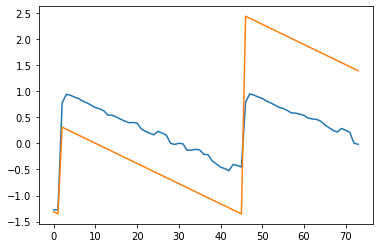

In [154]:
plt.plot(xgb_.predict(x_test),label='preds')
plt.plot(y_test)
plt.legends()
plt.show()

In [155]:
model = SVR().fit(x_train, y_train)
r1 = model.score(x_test, y_test)
r2 = mean_squared_error(model.predict(x_test),y_test)

In [156]:
r1,r2

(0.3794286880477973, 1.0179064850075812)

AttributeError: module 'matplotlib.pyplot' has no attribute 'legends'

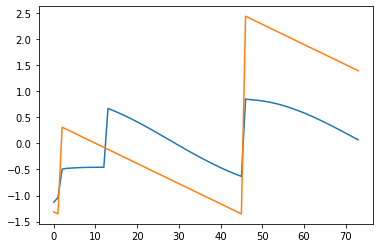

In [157]:
plt.plot(model.predict(x_test),label='preds')
plt.plot(y_test)
plt.legends
plt.show()